In [1]:
!pip install facenet-pytorch dask[distributed]

In [34]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile

import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, confusion_matrix,
    precision_recall_curve, average_precision_score
)
import seaborn as sns
from facenet_pytorch import InceptionResnetV1

from dask.distributed import Client, LocalCluster, as_completed

from google.colab import drive

In [33]:
drive.mount('/content/drive')

# Extract the LFW dataset
with tarfile.open("/content/drive/MyDrive/TDC/Data/lfw-funneled.tgz", "r") as tar:
    tar.extractall("data")

# Initialize Dask client with optimized configuration
cluster = LocalCluster(n_workers=1, threads_per_worker=2, memory_limit='4GB')
client = Client(cluster)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44173 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46451
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44173/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33913'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:36647', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36647
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53688
INFO:distributed.scheduler:Receive client connection: Client-ef73b0a5-8aa4-11ef-876c-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53694


In [4]:
def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        lines = f.readlines()
    # Skip the first line if it contains the number of pairs
    if lines[0].strip().isdigit():
        lines = lines[1:]
    for line in lines:
        line = line.strip()
        if len(line.split()) == 3:
            name, idx1, idx2 = line.split()
            pairs.append((name, idx1, name, idx2, 1))  # Label 1 for same person
        elif len(line.split()) == 4:
            name1, idx1, name2, idx2 = line.split()
            pairs.append((name1, idx1, name2, idx2, 0))  # Label 0 for different persons
    return pairs

In [5]:
train_pairs = read_pairs('/content/drive/MyDrive/TDC/Data/pairsDevTrain.txt')
test_pairs = read_pairs('/content/drive/MyDrive/TDC/Data/pairsDevTest.txt')

In [6]:
image_paths = set()
for pair in train_pairs + test_pairs:
    name1, idx1, name2, idx2, label = pair
    idx1_padded = str(idx1).zfill(4)
    idx2_padded = str(idx2).zfill(4)
    path1 = os.path.join('/content/data/lfw_funneled', name1, f'{name1}_{idx1_padded}.jpg')
    path2 = os.path.join('/content/data/lfw_funneled', name2, f'{name2}_{idx2_padded}.jpg')
    image_paths.add(path1)
    image_paths.add(path2)

In [7]:
# Convert image paths to a list for indexing
image_paths = list(image_paths)

In [8]:
def compute_embeddings_batch(image_paths_batch):
    # Initialize model and transform if not already initialized
    if not hasattr(compute_embeddings_batch, 'model'):
        from facenet_pytorch import InceptionResnetV1
        compute_embeddings_batch.model = InceptionResnetV1(pretrained='vggface2').eval().to('cuda')
        compute_embeddings_batch.transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
    model = compute_embeddings_batch.model
    transform = compute_embeddings_batch.transform

    images = []
    paths = []
    for image_path in image_paths_batch:
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)
        paths.append(image_path)
    images = torch.stack(images).to('cuda')
    with torch.no_grad():
        embeddings = model(images).cpu().numpy()
    # Return a list of (image_path, embedding) tuples
    return list(zip(paths, embeddings))

In [9]:
batch_size = 256  # You can try increasing this if you have more GPU memory

# Create batches of image paths
batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

# Compute embeddings in parallel using Dask
futures = client.map(compute_embeddings_batch, batches)

# Collect embeddings as they are computed
embeddings_dict = {}
for future in tqdm(as_completed(futures), total=len(futures)):
    try:
        batch_results = future.result()
        embeddings_dict.update(batch_results)
    except Exception as e:
        print(f"Error processing a future: {e}")

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


In [10]:
def compute_similarity(pair):
    name1, idx1, name2, idx2, label = pair
    idx1_padded = str(idx1).zfill(4)
    idx2_padded = str(idx2).zfill(4)
    path1 = os.path.join('/content/data/lfw_funneled', name1, f'{name1}_{idx1_padded}.jpg')
    path2 = os.path.join('/content/data/lfw_funneled', name2, f'{name2}_{idx2_padded}.jpg')
    embedding1 = embeddings_dict[path1]
    embedding2 = embeddings_dict[path2]
    # Compute cosine similarity
    similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    return (similarity, label)

In [36]:
def plot_image_pair(image_path1, image_path2, similarity):
    """
    Plots two images side by side with their cosine similarity.
    """
    img1 = mpimg.imread(image_path1)
    img2 = mpimg.imread(image_path2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Image 1')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Image 2')

    plt.suptitle(f"Cosine Similarity: {similarity:.4f}", fontsize=16)
    plt.show()

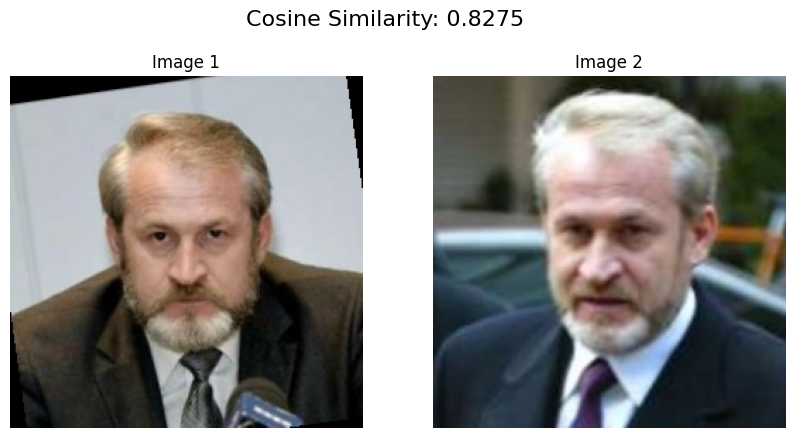

In [42]:
name1 = 'Akhmed_Zakayev'
idx1 = 1
name2 = 'Akhmed_Zakayev'
idx2 = 2

# Construct the image paths
path1 = os.path.join('/content/data/lfw_funneled', name1, f'{name1}_{str(idx1).zfill(4)}.jpg')
path2 = os.path.join('/content/data/lfw_funneled', name2, f'{name2}_{str(idx2).zfill(4)}.jpg')


if path1 in embeddings_dict and path2 in embeddings_dict:
    similarity, _ = compute_similarity((name1, idx1, name2, idx2, 0))
    plot_image_pair(path1, path2, similarity)
else:
    print(f"Embedding not found for {path1} or {path2}")

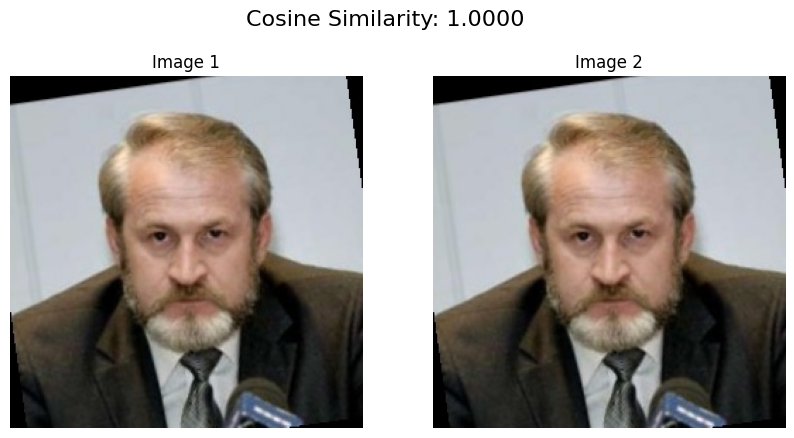

In [43]:
name1 = 'Akhmed_Zakayev'
idx1 = 1
name2 = 'Akhmed_Zakayev'
idx2 = 1

# Construct the image paths
path1 = os.path.join('/content/data/lfw_funneled', name1, f'{name1}_{str(idx1).zfill(4)}.jpg')
path2 = os.path.join('/content/data/lfw_funneled', name2, f'{name2}_{str(idx2).zfill(4)}.jpg')


if path1 in embeddings_dict and path2 in embeddings_dict:
    similarity, _ = compute_similarity((name1, idx1, name2, idx2, 0))
    plot_image_pair(path1, path2, similarity)
else:
    print(f"Embedding not found for {path1} or {path2}")

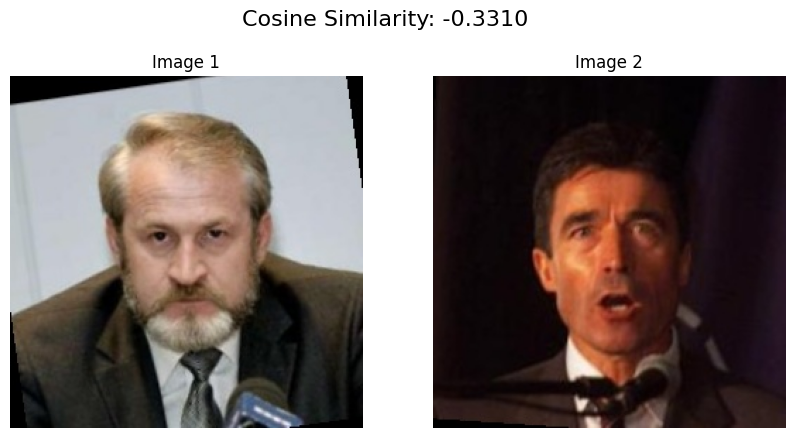

In [40]:
name1 = 'Akhmed_Zakayev'
idx1 = 1
name2 = 'Anders_Fogh_Rasmussen'
idx2 = 1

# Construct the image paths
path1 = os.path.join('/content/data/lfw_funneled', name1, f'{name1}_{str(idx1).zfill(4)}.jpg')
path2 = os.path.join('/content/data/lfw_funneled', name2, f'{name2}_{str(idx2).zfill(4)}.jpg')


if path1 in embeddings_dict and path2 in embeddings_dict:
    similarity, _ = compute_similarity((name1, idx1, name2, idx2, 0))
    plot_image_pair(path1, path2, similarity)
else:
    print(f"Embedding not found for {path1} or {path2}")

In [11]:
train_results = [compute_similarity(pair) for pair in tqdm(train_pairs)]
test_results = [compute_similarity(pair) for pair in tqdm(test_pairs)]

100%|██████████| 1000/1000 [00:00<00:00, 60608.70it/s]


In [12]:
train_results

[(0.854426, 1),
 (0.73066187, 1),
 (0.56582063, 1),
 (0.84884053, 1),
 (0.74050784, 1),
 (0.7626964, 1),
 (0.7694714, 1),
 (0.9121042, 1),
 (0.51305157, 1),
 (0.7181485, 1),
 (0.6724883, 1),
 (0.4400019, 1),
 (0.580032, 1),
 (0.50393945, 1),
 (0.71818876, 1),
 (0.75723624, 1),
 (0.7895761, 1),
 (0.89150554, 1),
 (0.888003, 1),
 (0.536759, 1),
 (0.7247699, 1),
 (0.6953018, 1),
 (0.8044449, 1),
 (0.92953265, 1),
 (0.63893104, 1),
 (0.78318244, 1),
 (0.8286055, 1),
 (0.6530335, 1),
 (0.6684255, 1),
 (0.4109794, 1),
 (0.3783003, 1),
 (0.70311815, 1),
 (0.53592014, 1),
 (0.7393762, 1),
 (0.83733326, 1),
 (0.87711096, 1),
 (0.61116976, 1),
 (0.72045213, 1),
 (0.88817495, 1),
 (0.8988907, 1),
 (0.46424466, 1),
 (0.811765, 1),
 (0.5306639, 1),
 (0.5584143, 1),
 (0.5651291, 1),
 (0.76024336, 1),
 (0.8641269, 1),
 (0.7786681, 1),
 (0.7145548, 1),
 (0.76982874, 1),
 (0.75786376, 1),
 (0.78656137, 1),
 (0.7642278, 1),
 (0.77225554, 1),
 (0.8631331, 1),
 (0.8744997, 1),
 (0.6582923, 1),
 (0.6625877

In [13]:
test_results

[(0.9017664, 1),
 (0.7093533, 1),
 (0.7886758, 1),
 (0.8250579, 1),
 (0.69094247, 1),
 (0.4971872, 1),
 (0.83572876, 1),
 (0.7388281, 1),
 (0.718525, 1),
 (0.66833526, 1),
 (0.7596733, 1),
 (0.57339877, 1),
 (0.58148307, 1),
 (0.6634458, 1),
 (0.8573121, 1),
 (0.80597913, 1),
 (0.82239544, 1),
 (0.660733, 1),
 (0.64521223, 1),
 (0.5222981, 1),
 (0.6849823, 1),
 (0.67858547, 1),
 (0.5618816, 1),
 (0.65022796, 1),
 (0.7115822, 1),
 (0.5471986, 1),
 (0.838099, 1),
 (0.77603006, 1),
 (0.8656653, 1),
 (0.78160024, 1),
 (0.5999438, 1),
 (0.75745165, 1),
 (0.81985873, 1),
 (0.5079632, 1),
 (0.8318619, 1),
 (0.8803214, 1),
 (0.79138035, 1),
 (0.76693916, 1),
 (0.88128304, 1),
 (0.90105146, 1),
 (0.7350065, 1),
 (0.32834375, 1),
 (0.7765078, 1),
 (0.6608484, 1),
 (0.5631826, 1),
 (0.60412586, 1),
 (0.6477755, 1),
 (0.66284126, 1),
 (0.68202287, 1),
 (0.50134844, 1),
 (0.70413965, 1),
 (0.6790791, 1),
 (0.84720415, 1),
 (0.7187925, 1),
 (0.6819294, 1),
 (0.5696749, 1),
 (0.60017806, 1),
 (0.8129

In [29]:
def plot_confusion_matrix(similarity_results, threshold=0.5):
    """
    Plot confusion matrix based on similarity threshold.
    """
    y_true = [label for _, label in similarity_results]
    y_pred = [1 if sim >= threshold else 0 for sim, _ in similarity_results]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

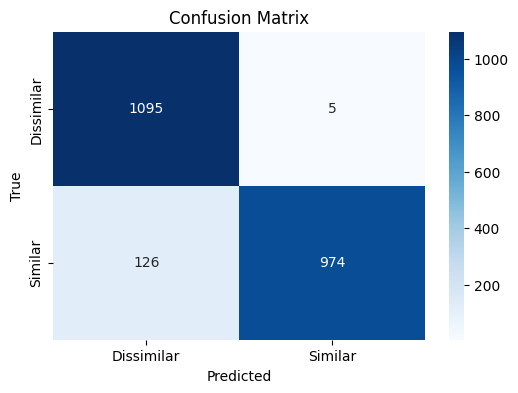

In [30]:
plot_confusion_matrix(train_results, threshold=0.5)

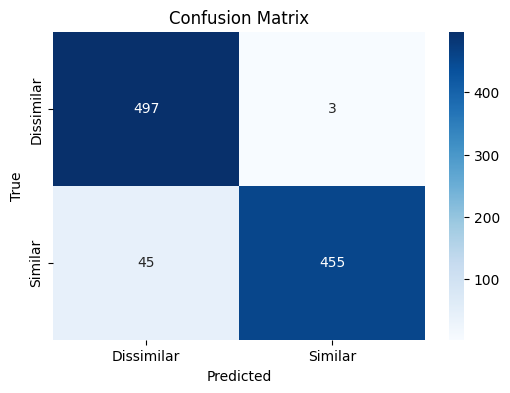

In [31]:
plot_confusion_matrix(test_results, threshold=0.5)

In [14]:
train_similarities, train_labels = zip(*train_results)
test_similarities, test_labels = zip(*test_results)

In [15]:
train_similarities = np.array(train_similarities)
train_labels = np.array(train_labels)
test_similarities = np.array(test_similarities)
test_labels = np.array(test_labels)

In [16]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_similarities)
roc_auc_train = auc(fpr_train, tpr_train)

In [17]:
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_similarities)
roc_auc_test = auc(fpr_test, tpr_test)

In [18]:
best_accuracy = 0
best_threshold = 0
for threshold in thresholds_train:
    predictions = (train_similarities >= threshold).astype(int)
    acc = accuracy_score(train_labels, predictions)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

In [19]:
test_predictions = (test_similarities >= best_threshold).astype(int)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Best threshold on train set: {best_threshold:.4f}")
print(f"Train set accuracy: {best_accuracy:.4f}")
print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"Test set ROC AUC: {roc_auc_test:.4f}")

Best threshold on train set: 0.3732
Train set accuracy: 0.9736
Test set accuracy: 0.9640
Test set ROC AUC: 0.9932


In [20]:
fnr_test = 1 - tpr_test
eer_threshold = thresholds_test[np.nanargmin(np.absolute((fnr_test - fpr_test)))]
eer = fpr_test[np.nanargmin(np.absolute((fnr_test - fpr_test)))]

In [21]:
print(f"Equal Error Rate (EER) threshold: {eer_threshold:.4f}")
print(f"Test set EER: {eer:.4f}")

Equal Error Rate (EER) threshold: 0.3965
Test set EER: 0.0340


In [22]:
cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[479  21]
 [ 15 485]]


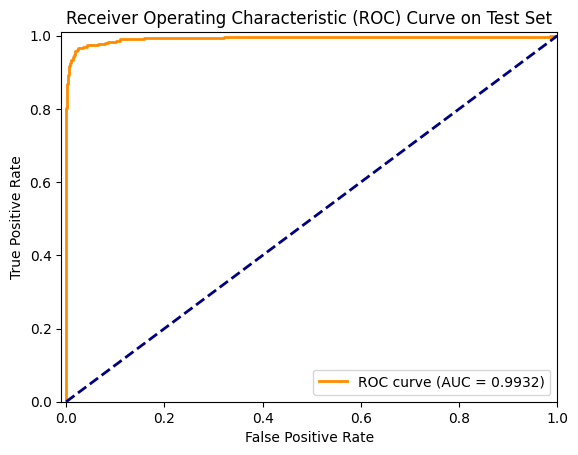

In [23]:
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

In [24]:
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_similarities)
average_precision = average_precision_score(test_labels, test_similarities)

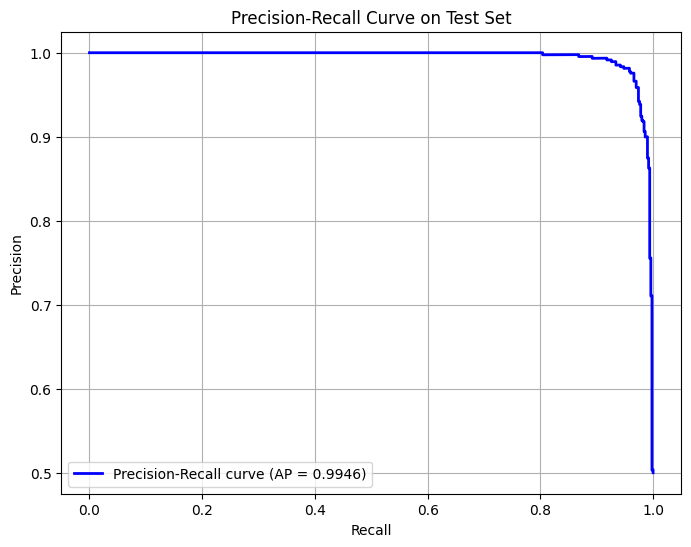

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.4f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Set')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

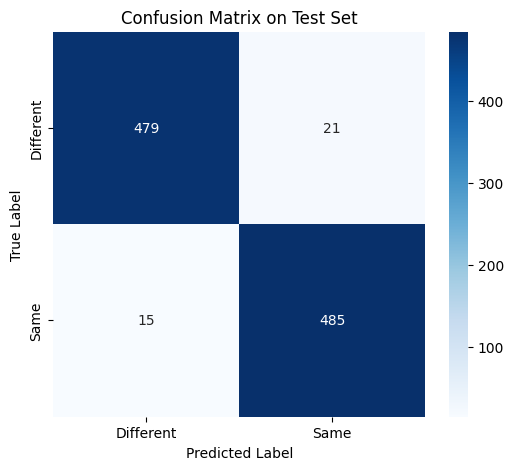

In [26]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

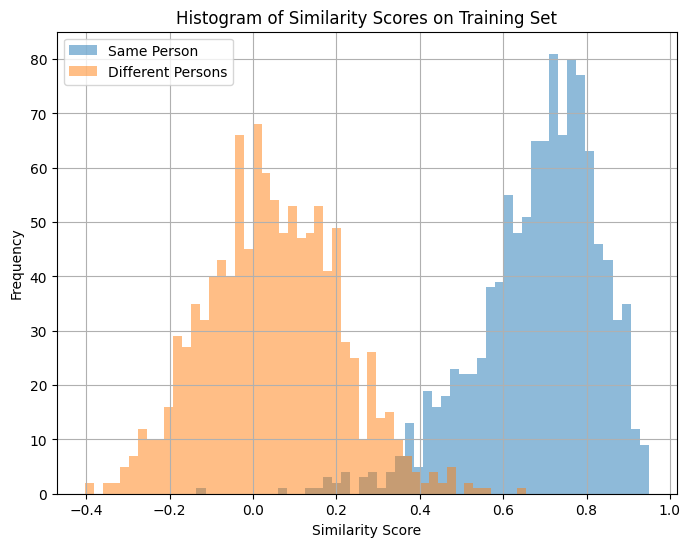

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(train_similarities[train_labels == 1], bins=50, alpha=0.5, label='Same Person')
plt.hist(train_similarities[train_labels == 0], bins=50, alpha=0.5, label='Different Persons')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores on Training Set')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

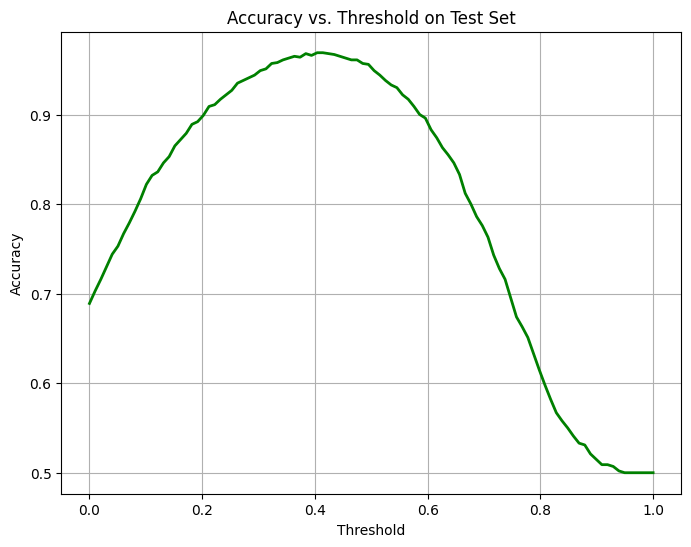

In [28]:
thresholds = np.linspace(0, 1, 100)
accuracies = []
for threshold in thresholds:
    predictions = (test_similarities >= threshold).astype(int)
    acc = accuracy_score(test_labels, predictions)
    accuracies.append(acc)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, color='green', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold on Test Set')
plt.grid(True)
plt.show()